In [1]:
# Import Libraries

library(Seurat)
library(Matrix)
library(dplyr)
library(stringr)
library(ggplot2)
library(ggrepel)
library(forcats)
library(pheatmap)
library(viridisLite)
library(dplyr)
library(matrixStats)
library(ComplexHeatmap)
library(circlize)
library(scales)

set.seed(14)

# Multicore CPU usage activation - Future

library(future)

# plan("multicore", workers = 24) # Mac Pro 6.1
# plan(workers = 36) # iMac Pro 1.1
# plan("multicore", workers = 8) # 4 core Intel CPU and M1 have 8 threads
# plan("multicore", workers = 12) # 6 core Intel CPU has 12 threads
plan("multicore", workers = 10) # 10 core M1 Pro CPU has 10 threads

# Set RAM Size to 3/4 of total RAM

# options(future.globals.maxSize = 48000 * 1024^2) # Mac Pros have 64 Gb
options(future.globals.maxSize = 16000 * 1024^2) # iMacs and MacBook Pros have 16 Gb

future.seed=TRUE # Removes future-generated statistical errors

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.3”
Registered S3 method overwritten by 'future':
  method               from      
  all.equal.connection parallelly


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘ggrepel’ was built under R version 4.3.3”
Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr

In [2]:
# File paths
RNA_CSV  <- "DeSeq2_normed_counts.csv"  # features x samples (rows = RNAs, cols = samples)
META_CSV <- "metadata.csv"       # rows = samples, cols = attributes

# 1) Load
sec_df <- read.csv(RNA_CSV, row.names = 1, check.names = FALSE)
meta   <- read.csv(META_CSV,     row.names = 1, check.names = FALSE, stringsAsFactors = FALSE)

# 2) Ensure orientation: rows = features, cols = samples
# (If your CSV already has this orientation, nothing changes.)
# If your metadata rownames match column names, you're good.
# If they match row names instead, transpose the expression matrix:
if (!all(rownames(meta) %in% colnames(sec_df))) {
  sec_df <- t(sec_df)
}

# 3) Make numeric, sanitize
raw_mat <- as.matrix(sec_df)
storage.mode(raw_mat) <- "numeric"
raw_mat[is.na(raw_mat)] <- 0
raw_mat[raw_mat < 0] <- 0  # guard, if any

# 4) log2(x+1) for the 'data' slot
norm_mat <- log2(raw_mat + 1)

# 5) Seurat object (assay = RNA)
obj <- CreateSeuratObject(counts = raw_mat, assay = "RNA", project = "RNA")
DefaultAssay(obj) <- "RNA"
obj <- SetAssayData(obj, assay = "RNA", slot = "data", new.data = norm_mat)

obj

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


An object of class Seurat 
42 features across 72 samples within 1 assay 
Active assay: RNA (42 features, 0 variable features)
 2 layers present: counts, data

In [3]:
# 6) Attach metadata

# 6a) Subset in the *same order* as object cells; KEEP data.frame structure
meta <- meta[colnames(obj), , drop = FALSE]

# 6b) Drop columns that are all NA or empty strings
keep_cols <- vapply(meta, function(x) any(!is.na(x) & nzchar(as.character(x))), logical(1))
meta <- meta[, keep_cols, drop = FALSE]

# 6c) Make sure rownames (sample IDs) survived and match
stopifnot(identical(rownames(meta), colnames(obj)))

# 6d) If metadata has only 1 column, AddMetaData expects a *named vector* or a 1-col data.frame.
if (ncol(meta) == 1) {
  v <- meta[[1]]
  names(v) <- rownames(meta)    # names must be cell/sample IDs
  obj[[colnames(meta)[1]]] <- v # add as a single metadata field
} else {
  obj <- AddMetaData(obj, metadata = meta)
}

obj@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,Group,Sample,Batch
,<fct>,<dbl>,<int>,<chr>,<int>,<chr>
1,RNA,1235.8655,42,Non-TD,1,Cartridge 1
2,RNA,1714.0034,42,Non-TD,2,Cartridge 1
3,RNA,1569.1993,42,Non-TD,3,Cartridge 1
4,RNA,3245.4878,39,Non-TD,4,Cartridge 2
5,RNA,1617.9739,40,Non-TD,5,Cartridge 2
6,RNA,1270.4556,36,Non-TD,6,Cartridge 2
7,RNA,2620.0413,38,Non-TD,7,Cartridge 4
8,RNA,1990.0320,36,Non-TD,8,Cartridge 4
9,RNA,1500.5339,38,Non-TD,9,Cartridge 4


In [4]:
# 7) Scale & PCA
VariableFeatures(obj, assay = "RNA") <- rownames(obj[["RNA"]])
obj <- ScaleData(obj, assay = "RNA",
                 features = VariableFeatures(obj, "RNA"), verbose = FALSE)

npcs <- max(2, min(30, ncol(obj) - 1, nrow(obj) - 1))
obj <- RunPCA(obj, assay = "RNA",
              features = VariableFeatures(obj, "RNA"),
              npcs = npcs, reduction.name = "pca.rna", verbose = FALSE)

Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


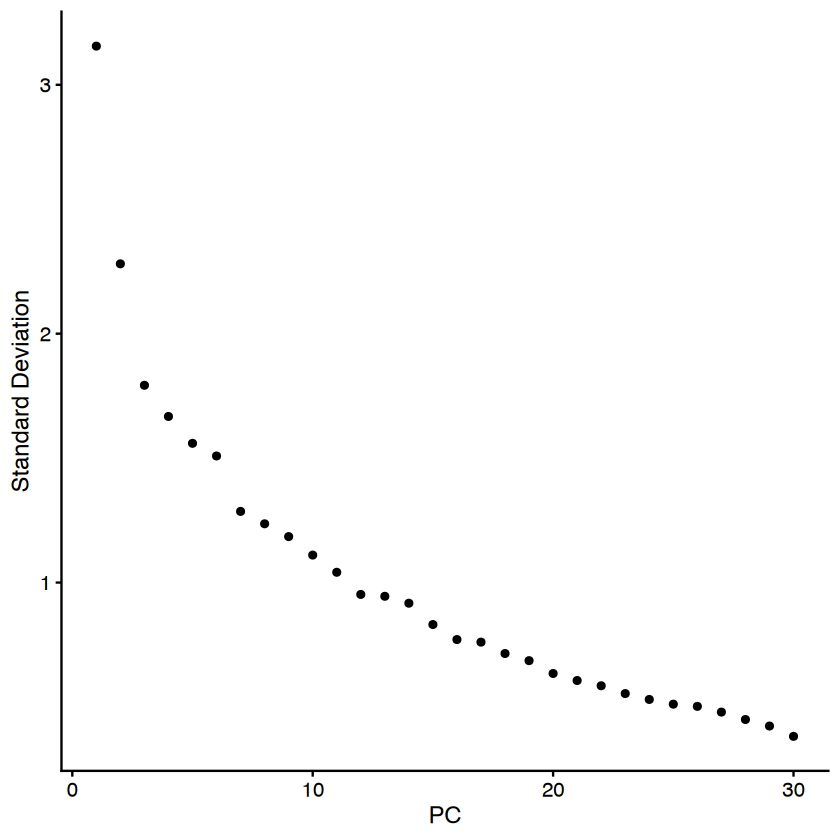

In [5]:
ElbowPlot(obj, ndims = 30, 
          reduction = "pca.rna"
         )

In [6]:
dims_use <- 1:14

# Build the SNN graph and run UMAP using your custom PCA reduction
obj <- FindNeighbors(obj, reduction = "pca.rna", dims = dims_use, verbose = FALSE)
obj <- RunUMAP(obj, reduction = "pca.rna", dims = dims_use, reduction.name = "UMAP", verbose = FALSE)

# Pick a grouping column to color by (change to what you have in obj@meta.data)
group_col <- intersect(c("Group"),
                       colnames(obj@meta.data))
group_col <- if (length(group_col)) group_col[1] else NULL


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


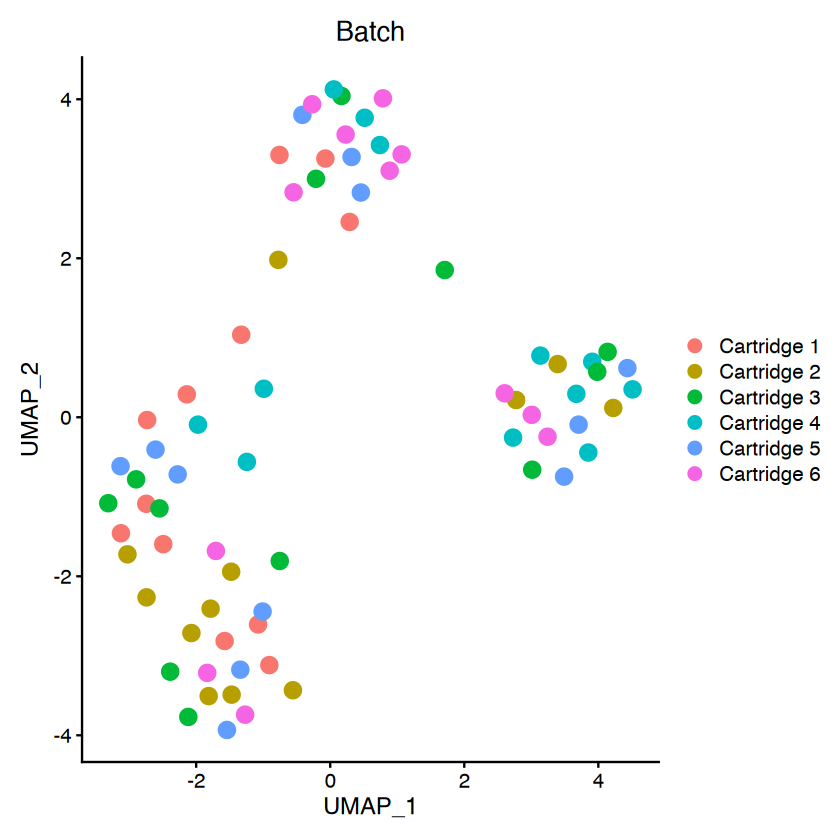

In [7]:
DimPlot(obj, reduction = "UMAP", group.by  = "Batch",
        pt.size = 4, label.size= 10,
        label = FALSE, repel = TRUE)

ggsave(
  "Batch.jpeg",
  plot   = last_plot(),
  width  = 17.35,
  height = 15,
  units  = "cm",
  dpi    = 600,
  limitsize = TRUE,
  bg     = "white"
)

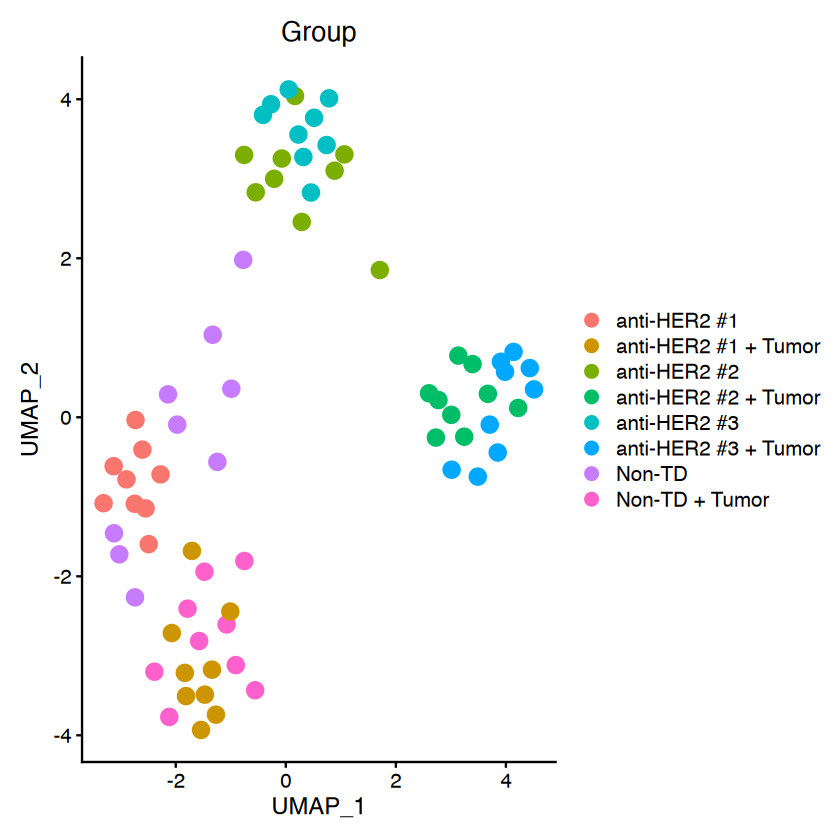

In [8]:
DimPlot(obj, reduction = "UMAP", group.by  = "Group",
        pt.size = 4, label.size= 10,
        label = FALSE, repel = TRUE)

ggsave(
  "Group.jpeg",
  plot   = last_plot(),
  width  = 19.5,
  height = 15,
  units  = "cm",
  dpi    = 600,
  limitsize = TRUE,
  bg     = "white"
)   

In [10]:
# Split by biogroup

stopifnot(all(c("Sample","Group") %in% colnames(obj@meta.data)))

obj$Sample_Group <- paste(obj$Group,obj$Sample, sep = "_")

combo <- unique(obj@meta.data[, c("Group","Sample","Sample_Group")])
combo <- combo[order(combo$Group, combo$Sample), , drop = FALSE]
ordered_levels <- combo$Sample_Group

obj$Sample_Group <- factor(obj$Sample_Group,
                                           levels = ordered_levels)

In [11]:
rownames(obj[["RNA"]])

[1] "ADORA2A"  "ADORA2B"  "CD4"      "CD8A"     "CD27"     "CD28"    
 [7] "CD40"     "CD45R0"   "CD45RA"   "CD272"    "CD274"    "CD276"   
[13] "CTLA4"    "CTLA4-TM" "EOMES"    "FAS"      "FASLG"    "FOXP3"   
[19] "GNLY"     "GZMA"     "GZMB"     "GZMH"     "GZMK"     "GZMM"    
[25] "HAVCR2"   "ICOS"     "IFNG"     "IL2RA"    "IL2RG"    "IL7R"    
[31] "LAG3"     "NOX2"     "PRF1"     "SELL"     "SIGLEC7"  "TNF"     
[37] "TNFRSF4"  "TNFRSF9"  "TNFRSF18" "TNFSF18"  "VISTA"    "VTCN1"

In [12]:
# genes <- c(
#   "FASLG","GNLY","GZMA","GZMB","GZMH","GZMK","GZMM","IFNG","PRF1","TNF",
#   "ADORA2A","ADORA2B","VISTA","CD272","CD274","CD276","CTLA4","CTLA4-TM","HAVCR2",
#   "LAG3","NOX2","SIGLEC7","VTCN1","CD27","CD28","CD40","ICOS","TNFRSF18","TNFRSF4",
#   "TNFRSF9","TNFSF18","CD4","CD45R0","CD45RA","CD8A","EOMES","FAS","IL2RA","IL2RG","IL7R","SELL","FOXP3"
# )

In [13]:
# DefaultAssay(obj) <- "RNA"
# Idents(obj) <- "Group"   # or "Sample_Group"

# p <- DotPlot(
#   obj,
#   features   = genes,
#   # dot.scale  = 6,                 # << increase this (e.g., 6–12) for larger dots
#   scale.by   = "radius",           # default; keeps area perceptual
# ) + RotatedAxis() + scale_colour_gradient2(low = "blue", mid = "white", high = "red") + coord_flip() + theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1))
# # + theme(axis.text.x = element_text(angle = 90))
# print(p)

# ggsave(
#   filename = "Dot Plot Samples.jpeg",
#   plot     = p,
#   width    = 18,
#   height   = 38,
#   units    = "cm",
#   dpi      = 600,
#   limitsize = TRUE,
#   bg       = "white"
# )

In [14]:
# cytotox <- c("FASLG","GNLY","GZMA","GZMB","GZMH","GZMK","GZMM","IFNG","PRF1","TNF")

# pheno <- c("CD4","CD45R0","CD45RA","CD8A","EOMES","FAS","IL2RA","IL2RG","IL7R","SELL","FOXP3")

# check_pos <- c("CD27","CD28","CD40","ICOS","TNFRSF18","TNFRSF4","TNFRSF9","TNFSF18")

# check_neg <- c("ADORA2A","ADORA2B","VISTA","CD272","CD274","CD276","CTLA4","CTLA4-TM","HAVCR2","LAG3","NOX2","SIGLEC7","VTCN1")

In [15]:
# DefaultAssay(obj) <- "RNA"
# Idents(obj) <- "Group"   # or "Sample_Group"

# p <- DotPlot(
#   obj,
#   features   = cytotox,
#   dot.scale  = 7,                 # << increase this (e.g., 6–12) for larger dots
#   scale.by   = "radius",           # default; keeps area perceptual
# ) + RotatedAxis() + scale_colour_gradient2(low = "blue", mid = "white", high = "red") + theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1))
# # + theme(axis.text.x = element_text(angle = 90))
# print(p)

# ggsave(
#   filename = "Dot Plot Cytotox.jpeg",
#   plot     = p,
#   width    = 30,
#   height   = 10,
#   units    = "cm",
#   dpi      = 600,
#   limitsize = TRUE,
#   bg       = "white"
# )

# p <- DotPlot(
#   obj,
#   features   = pheno,
#   dot.scale  = 7,                 # << increase this (e.g., 6–12) for larger dots
#   scale.by   = "radius",           # default; keeps area perceptual
# ) + RotatedAxis() + scale_colour_gradient2(low = "blue", mid = "white", high = "red") + theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1))
# # + theme(axis.text.x = element_text(angle = 90))
# print(p)

# ggsave(
#   filename = "Dot Plot Phenotypes.jpeg",
#   plot     = p,
#   width    = 30,
#   height   = 10,
#   units    = "cm",
#   dpi      = 600,
#   limitsize = TRUE,
#   bg       = "white"
# )

# p <- DotPlot(
#   obj,
#   features   = check_pos,
#   dot.scale  = 7,                 # << increase this (e.g., 6–12) for larger dots
#   scale.by   = "radius",           # default; keeps area perceptual
# ) + RotatedAxis() + scale_colour_gradient2(low = "blue", mid = "white", high = "red") + theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1))
# print(p)

# ggsave(
#   filename = "Dot Plot Pos Check.jpeg",
#   plot     = p,
#   width    = 30,
#   height   = 10,
#   units    = "cm",
#   dpi      = 600,
#   limitsize = TRUE,
#   bg       = "white"
# )

# p <- DotPlot(
#   obj,
#   features   = check_neg,
#   dot.scale  = 7,                 # << increase this (e.g., 6–12) for larger dots
#   scale.by   = "radius",           # default; keeps area perceptual
# ) + RotatedAxis() + scale_colour_gradient2(low = "blue", mid = "white", high = "red") + theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1))
# # + theme(axis.text.x = element_text(angle = 90))
# print(p)

# ggsave(
#   filename = "Dot Plot Neg Check.jpeg",
#   plot     = p,
#   width    = 30,
#   height   = 10,
#   units    = "cm",
#   dpi      = 600,
#   limitsize = TRUE,
#   bg       = "white"
# )

In [ ]:
# Heatmap

assay_name <- "RNA" 
topN <- 100              
outfile <- "RNA_heatmap.jpeg"

DefaultAssay(obj) <- assay_name
mat <- tryCatch(
  GetAssayData(obj, assay = assay_name, layer = "data"),
  error = function(e) GetAssayData(obj, assay = assay_name, slot = "data")
)

meta_df <- obj@meta.data
stopifnot(all(c("Sample","Group") %in% colnames(meta_df)))
if (!"Sample_Group" %in% colnames(meta_df)) {
  # fallback: build it if missing (e.g., "S1_HER2-1")
  meta_df$Sample_Group <- paste0(meta_df$Sample, "_", meta_df$Group)
}

ann_col <- data.frame(
  Sample       = factor(meta_df$Sample, levels = sort(unique(meta_df$Sample))),
  Group        = factor(meta_df$Group),
  Sample_Group = as.character(meta_df$Sample_Group),   # free text for labels
  row.names = colnames(mat),
  check.names = FALSE
)

ord <- order(ann_col$Group, ann_col$Sample, na.last = TRUE)
mat      <- mat[, ord, drop = FALSE]
ann_col  <- ann_col[ord, , drop = FALSE]

col_labels <- ann_col$Sample_Group

if (is.infinite(topN) || topN >= nrow(mat)) {
  mat_sub <- mat
} else {
  v <- rowSds(as.matrix(mat))
  sel <- order(v, decreasing = TRUE)[seq_len(min(topN, nrow(mat)))]
  mat_sub <- mat[sel, , drop = FALSE]
}

mat_sub[!is.finite(mat_sub)] <- 0

mat_z <- t(scale(t(as.matrix(mat_sub))))
mat_z[!is.finite(mat_z)] <- 0
mat_z <- pmin(pmax(mat_z, -3), 3)


bwr_cols <- c("#313695","#4575B4","#74ADD1","#ABD9E9","#E0F3F8",
              "#FFFFFF",
              "#FEE090","#FDAE61","#F46D43","#D73027","#A50026")
col_fun <- circlize::colorRamp2(seq(-3, 3, length.out = length(bwr_cols)), bwr_cols)

grp_levels <- levels(ann_col$Group)
grp_cols   <- setNames(viridisLite::viridis(length(grp_levels)), grp_levels)

s_levels <- levels(ann_col$Sample)
smp_cols <- if ("package:Seurat" %in% search() && "DiscretePalette" %in% getNamespaceExports("Seurat")) {
  setNames(Seurat::DiscretePalette(length(s_levels)), s_levels)
} else {
  setNames(scales::hue_pal()(length(s_levels)), s_levels)
}

ha_top <- HeatmapAnnotation(
  Sample = ann_col$Sample,
  Group  = ann_col$Group,
  col = list(Sample = smp_cols, Group = grp_cols),
  annotation_name_side = "left",
  gap = unit(2, "mm")
)

In [ ]:
# Plot and save

ht <- Heatmap(
  mat_z,
  name = "z",
  col = col_fun,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_row_names = TRUE,
  show_column_names = TRUE,
  column_labels = col_labels,    # <-- now shows Sample_Group
  top_annotation = ha_top, 
  column_split = ann_col$Group,
  cluster_column_slices = FALSE,
  use_raster = TRUE,
  raster_quality = 2,
  row_title = "RNAs",
  column_title = "Samples",
  heatmap_legend_param = list(title = "Row z-score")
)

if (!requireNamespace("ragg", quietly = TRUE)) {
  install.packages("ragg", repos = "https://cloud.r-project.org")
}

width_in <- 19.5; height_in <- 16; dpi <- 600

ragg::agg_jpeg(outfile, width = width_in, height = height_in, units = "in", res = dpi)
draw(ht, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

message(sprintf("Saved heatmap to '%s' (%.1f x %.1f in @ %d dpi).",
                outfile, width_in, height_in, dpi))

In [ ]:
# Save object if needed 
saveRDS(obj, file = "RNA.rds")

In [16]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: Asia/Yerevan
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.40.0         scales_1.4.0          circlize_0.4.16      
 [4] ComplexHeatmap_2.18.0 matrixStats_1.5.0     viridisLite_0.4.2    
 [7] pheatmap_1.0.12       forcats_1.0.0         ggrepel_0.9.6        
[10] ggplot2_3.5.2         stringr_1.5.1         dplyr_1.1.4          
[13] Matrix_1.6-4          Seurat_5.2.1          SeuratObject_5.1.0   
[16] sp_2.2-0             

loaded via a namespace (an